In [154]:
%matplotlib inline

import pickle
import datetime
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = "/workspace/dataset/"
train_file = "train_sample.csv"
dev_file = "dev_sample.csv"
test_file = "test_sample.csv"

In [2]:
train_df = pd.read_csv(data_path + train_file)

In [3]:
train_df.columns

Index(['bcateid', 'brand', 'dcateid', 'maker', 'mcateid', 'model', 'pid',
       'price', 'product', 'scateid', 'updttm'],
      dtype='object')

## make tag dict

In [67]:
exception_word_list = ["참조", "없음", "표기", "별도", "상세", "자체", "불명", "미입력", "공개불가"]
exception_tag_list = ["기타", "", "."]

def check_valid(keyword):
    if keyword is np.nan:
        return False
    else:
        if any(exception in keyword for exception in exception_word_list):
            return False
        elif keyword in exception_tag_list:
            return False
        else:
            return True

def get_trimed_tag(brand, maker):
    brand_valid = check_valid(brand)
    maker_valid = check_valid(maker)
    if brand_valid:
        return brand
    else:
        if maker_valid:
            return maker
    return ""

train_df['tag'] = train_df.apply(lambda x: get_trimed_tag(x['brand'], x['maker']), axis=1)

In [68]:
valid_tag_list = train_df['tag'].value_counts()[train_df['tag'].value_counts() > 30].index
print(len(valid_tag_list)) # 가지고있는 아이템의 개수가 30개 이상인 브랜드의 개수
print(train_df[train_df['tag'].isin(valid_tag_list)].shape) # 위의 브랜드를 포함하는 전체 데이터의 개수

15639
(7308679, 12)


In [69]:
print(train_df[train_df['tag'] == ""].shape) # outlier에 해당하는 tag 개수

(3857465, 12)


In [70]:
# 30개 이상 아이템을 가지고 있는 브랜드이면서, outlier에 해당하는 브랜드를 제외한 브랜드를 가지고 있는 데이터
print((7308567 - 3855743) / train_df.shape[0]) # 약 42% 정도가 '의미를 가질 확률이 높은' 브랜드 정보를 가지고 있음
print((train_df.shape[0] - 7308567) / train_df.shape[0]) # 약 10% 정도가 30개 미만의 아이템을 가지고 있는 브랜드 정보를 가지고 있음

0.4244500614518973
0.10156969707250979


In [85]:
train_df[train_df['tag'].isin(valid_tag_list)][['brand', 'maker', 'tag']].sample(100).head(50)

In [72]:
valid_tag_dict = {}

idx = 1
for tag in valid_tag_list:
    valid_tag_dict[tag] = idx
    idx = idx + 1

In [75]:
len(valid_tag_dict)
# valid_tag_dict

15639

In [78]:
# save
with open('valid_tag_dict.pickle', 'wb') as f:
    pickle.dump(valid_tag_dict, f, pickle.HIGHEST_PROTOCOL)

In [80]:
del train_df['brand']
del train_df['maker']
del train_df['tag']

## make price dict

In [83]:
pd.options.display.float_format = '{:.6f}'.format

In [84]:
train_df[(train_df['price']!=-1) & (train_df['price'] < 1000000)]['price'].describe()

count   2824493.000000
mean      67166.235912
std      114755.604384
min           1.000000
25%       12620.000000
50%       27710.000000
75%       67110.000000
max      999990.000000
Name: price, dtype: float64

In [117]:
quantile_1 = train_df[train_df['price']!=-1]['price'].quantile(0.3)
quantile_2 = train_df[train_df['price']!=-1]['price'].quantile(0.7)

print("quantile 1", str(train_df[train_df['price']!=-1]['price'].quantile(0.3)))
print("quantile 2", str(train_df[train_df['price']!=-1]['price'].quantile(0.7)))

quantile 1 15120.0
quantile 2 56100.0


In [118]:
def get_price_level(price):
    if price == -1:
        return "2"
    elif price == np.nan:
        return "2"
    else:
        if price < quantile_1:
            return "1"
        elif price > quantile_2:
            return "3"
        else:
            return "2"

train_df['price_level'] = train_df['price'].apply(lambda x: get_price_level(x))

In [119]:
train_df['price_level'].value_counts()

2    6416798
3     859121
1     858899
Name: price_level, dtype: int64

In [120]:
vc = train_df['price_level'].value_counts()
val_sum = vc.sum()
print(vc.index[0], "ratio :", str(vc.values[0] / val_sum))
print(vc.index[1], "ratio :", str(vc.values[1] / val_sum))
print(vc.index[2], "ratio :", str(vc.values[2] / val_sum))

2 ratio : 0.7888065842407291
3 ratio : 0.10561035292983814
1 ratio : 0.1055830628294327


In [122]:
price_quantile_dict = {"quantile_1": quantile_1, "quantile_2": quantile_2}

In [123]:
# save
with open('price_quantile_dict.pickle', 'wb') as f:
    pickle.dump(price_quantile_dict, f, pickle.HIGHEST_PROTOCOL)

## make aging min-max scaler dict for each div(train, dev, test)

In [125]:
del train_df['price_level']
del train_df['price']

In [170]:
time_aging_dict = {'train': {'min': 0,
                             'max': 0, 
                             'stand_unix_time': 0},
                   'dev': {'min': 0,
                           'max': 0, 
                           'stand_unix_time': 0},
                   'test': {'min': 0,
                            'max': 0, 
                            'stand_unix_time': 0}}

In [171]:
train_df['year_mon_day'] = train_df['updttm'].apply(lambda x: int(str(x[2:10])))
train_recent_updttm_day = train_df['year_mon_day'].max()
unix_time = time.mktime(datetime.datetime.strptime(str(train_recent_updttm_day), "%Y%m%d").timetuple())
time_aging_dict['train']['stand_unix_time'] = unix_time + 86400

In [172]:
dev_df = pd.read_csv(data_path + dev_file)
dev_df['year_mon_day'] = dev_df['updttm'].apply(lambda x: int(str(x[2:10])))
dev_recent_updttm_day = dev_df['year_mon_day'].max()
unix_time = time.mktime(datetime.datetime.strptime(str(dev_recent_updttm_day), "%Y%m%d").timetuple())
time_aging_dict['dev']['stand_unix_time'] = unix_time + 86400

In [173]:
test_df = pd.read_csv(data_path + test_file)
test_df['year_mon_day'] = test_df['updttm'].apply(lambda x: int(str(x[2:10])))
test_recent_updttm_day = test_df['year_mon_day'].max()
unix_time = time.mktime(datetime.datetime.strptime(str(test_recent_updttm_day), "%Y%m%d").timetuple())
time_aging_dict['test']['stand_unix_time'] = unix_time + 86400

In [174]:
time_aging_dict

{'dev': {'max': 0, 'min': 0, 'stand_unix_time': 1540825200.0},
 'test': {'max': 0, 'min': 0, 'stand_unix_time': 1540825200.0},
 'train': {'max': 0, 'min': 0, 'stand_unix_time': 1525100400.0}}

In [187]:
def get_unix_time_aging(stand_unix_time, time_str):
    date_str = time_str[2:10]
    unix_time = time.mktime(datetime.datetime.strptime(date_str, "%Y%m%d").timetuple())
    return (stand_unix_time - unix_time)

div_time_aging = time_aging_dict['train']['stand_unix_time']
train_df['unix_time_aging'] = train_df['updttm'].apply(lambda x: get_unix_time_aging(div_time_aging, x))

div_time_aging = time_aging_dict['dev']['stand_unix_time']
dev_df['unix_time_aging'] = dev_df['updttm'].apply(lambda x: get_unix_time_aging(div_time_aging, x))

div_time_aging = time_aging_dict['test']['stand_unix_time']
test_df['unix_time_aging'] = test_df['updttm'].apply(lambda x: get_unix_time_aging(div_time_aging, x))

In [188]:
time_aging_dict['train']['min'] = train_df['unix_time_aging'].min()
time_aging_dict['train']['max'] = train_df['unix_time_aging'].max()

time_aging_dict['dev']['min'] = dev_df['unix_time_aging'].min()
time_aging_dict['dev']['max'] = dev_df['unix_time_aging'].max()

time_aging_dict['test']['min'] = test_df['unix_time_aging'].min()
time_aging_dict['test']['max'] = test_df['unix_time_aging'].max()

print(time_aging_dict)

{'dev': {'stand_unix_time': 1540825200.0, 'min': 86400.0, 'max': 114825600.0}, 'test': {'stand_unix_time': 1540825200.0, 'min': 86400.0, 'max': 114998400.0}, 'train': {'stand_unix_time': 1525100400.0, 'min': 86400.0, 'max': 99100800.0}}


In [193]:
train_min = time_aging_dict['train']['min']
train_max = time_aging_dict['train']['max']

train_df['unix_time_norm'] = (train_df['unix_time_aging'] - train_min) / (train_max - train_min)

In [194]:
# save
with open('time_aging_dict.pickle', 'wb') as f:
    pickle.dump(time_aging_dict, f, pickle.HIGHEST_PROTOCOL)

## aging feature visualization

#### train distribution

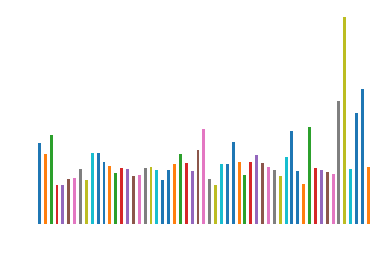

In [182]:
plt.axis('off')
train_df.groupby('bcateid')['unix_time_norm'].mean().plot.bar()

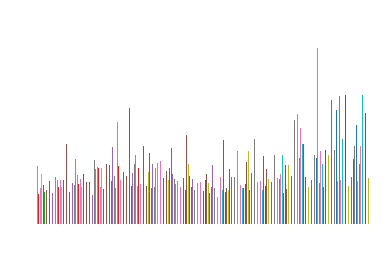

In [183]:
plt.axis('off')
train_df.groupby('mcateid')['unix_time_norm'].mean().plot.bar()

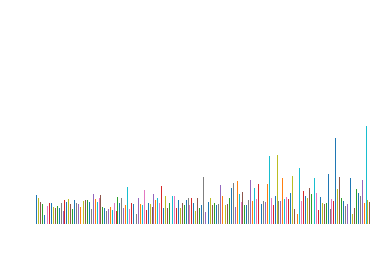

In [184]:
plt.axis('off')
train_df.groupby('scateid')['unix_time_norm'].mean().plot.bar()

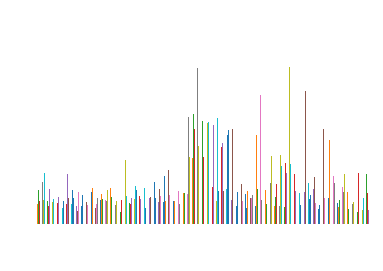

In [185]:
plt.axis('off')
train_df.groupby('dcateid')['unix_time_norm'].mean().plot.bar()